## Initialising model and libraries

In [8]:
import sys

sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM,MNIST_SResFITDM_Large,Omniglot
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
import numpy as np
from pytorch_lightning import seed_everything

import seaborn as sns
import matplotlib.pyplot as plt


trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/CelebA/mamba/sum/Mamba_CelebA_sum__wp_1000_L_8_H_8_s_12_subset_False_08-04_18-48-33/epoch=696-step=1742500.ckpt'
# trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/CelebA/fast/sum/Fast_CelebA_sum__wp_1000_L_8_H_8_s_5_subset_False_08-04_18-18-18/epoch=221-step=555000.ckpt'

dataset = trained_model_path.split('/')[-5]
model_type = trained_model_path.split('/')[-4]
loss = trained_model_path.split('/')[-3]

seed_everything(22122020)
dataset = "omniglot"
if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=32, subset_flag=False)
if dataset == "MNIST_large":
    dm = MNIST_SResFITDM_Large(root_dir="./datamodules/data/",
                            batch_size=2, subset_flag=False)
if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=8, subset_flag=False)
if dataset == "omniglot":
    dm = Omniglot(root_dir="./datamodules/data/",batch_size=8, subset_flag=False)

dm.prepare_data()
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss=loss,
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells = 12,
                              model_type = model_type)


# weights = torch.load(trained_model_path)['state_dict']
# model.load_state_dict(weights, strict=True)
model.cuda()
model.eval()
print('Model Loaded')

Seed set to 22122020


Model Loaded


In [33]:
loss=torch.tensor(2.33e+11); amp_loss=torch.tensor(1) ; phi_loss=torch.tensor(0.999)

In [36]:
max(torch.pow(10,torch.round(torch.log10(amp_loss))),1)

tensor(1.)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


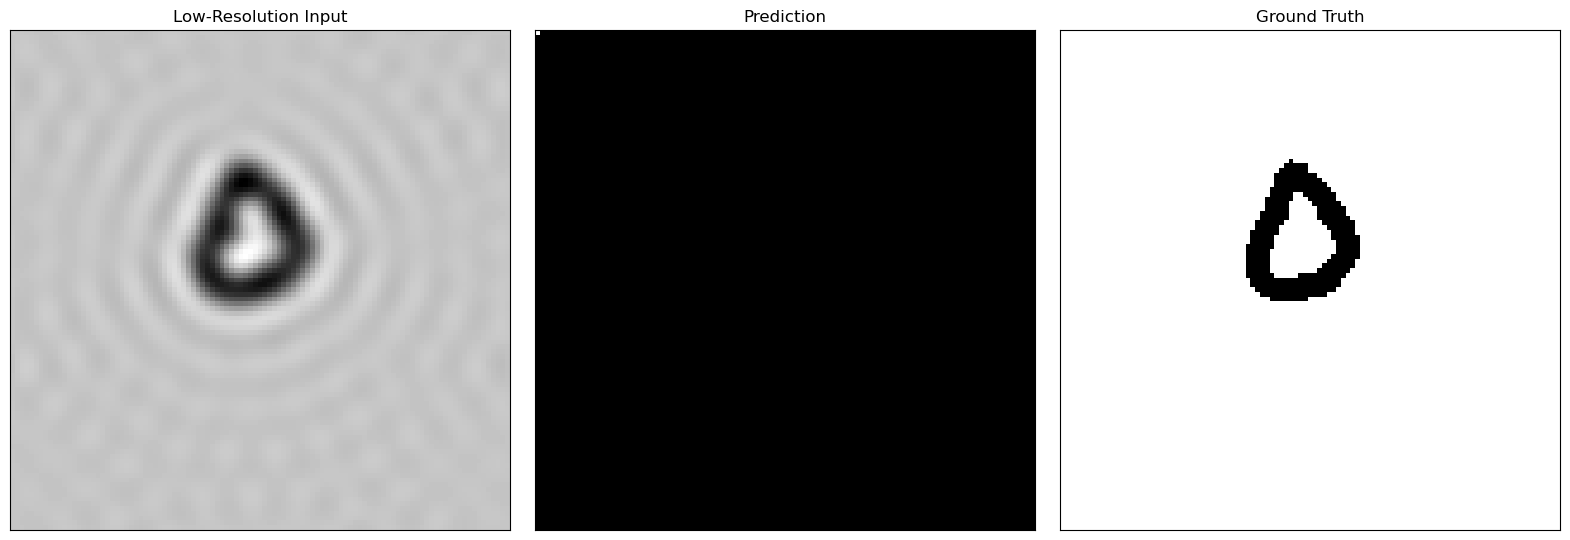

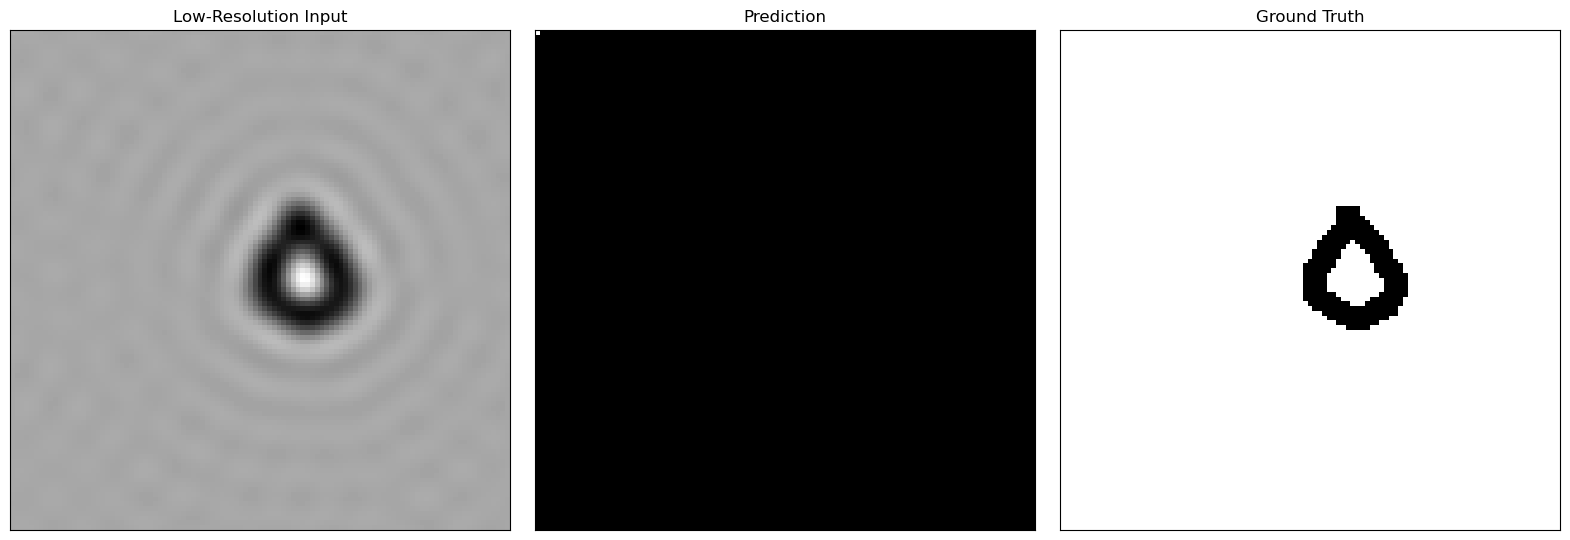

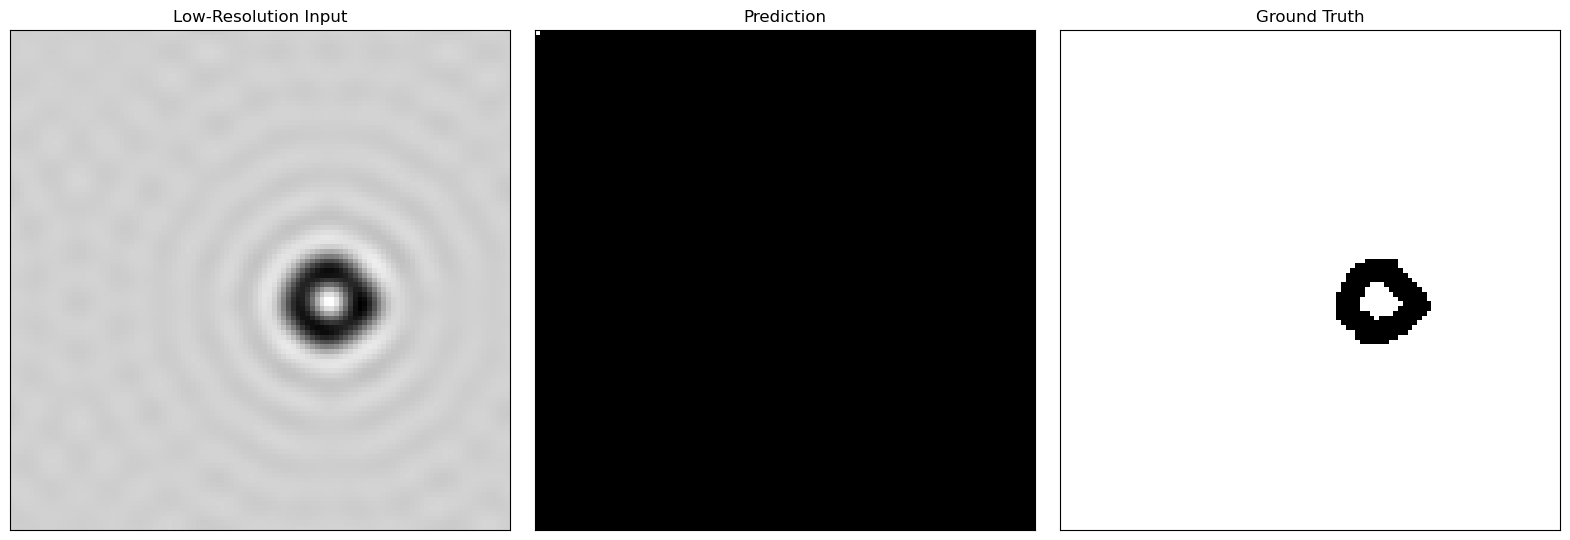

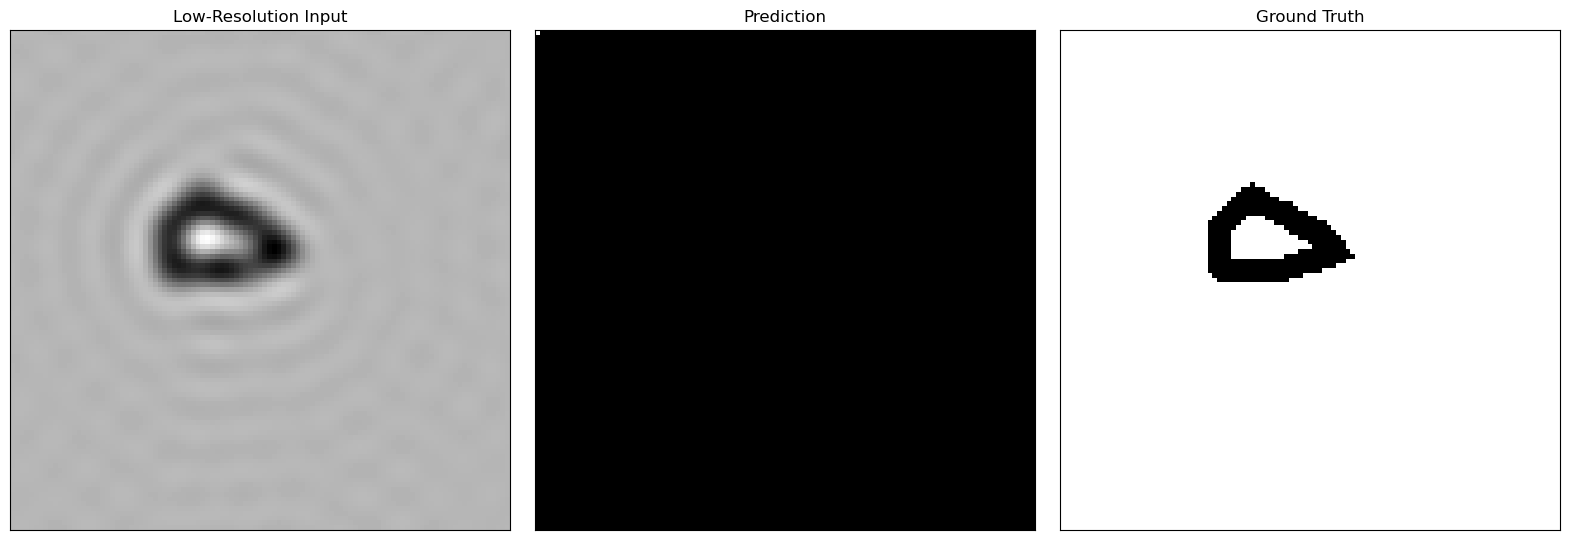

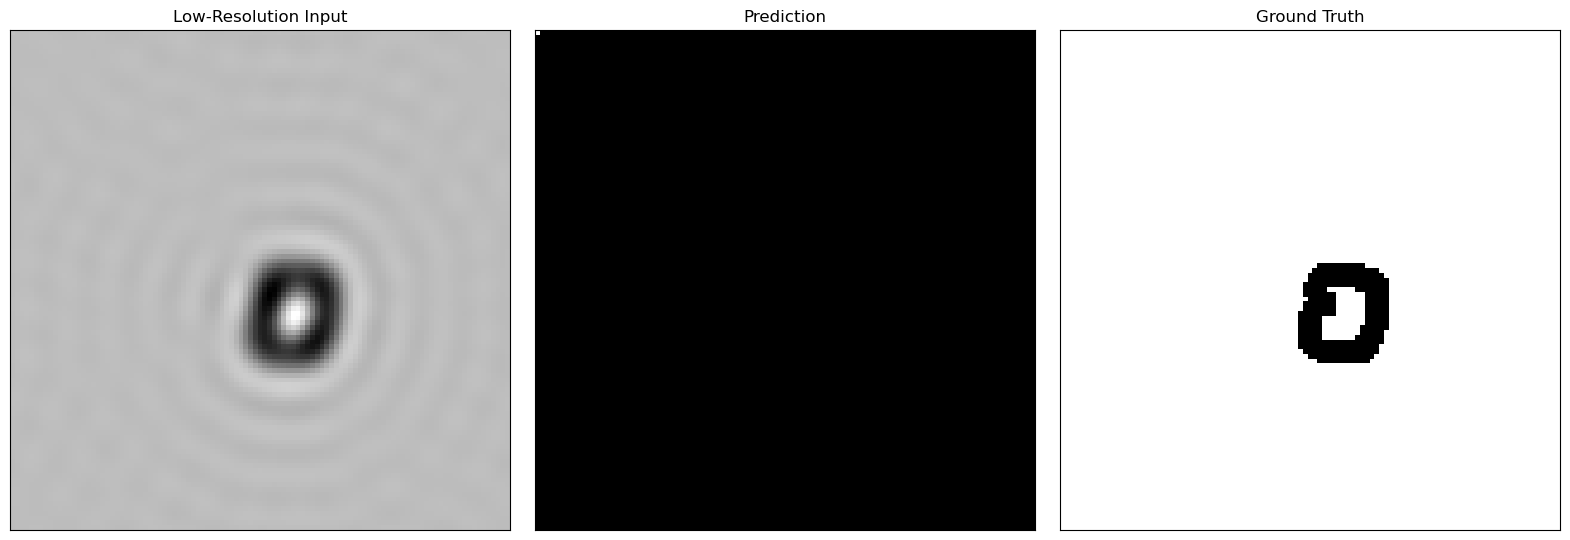

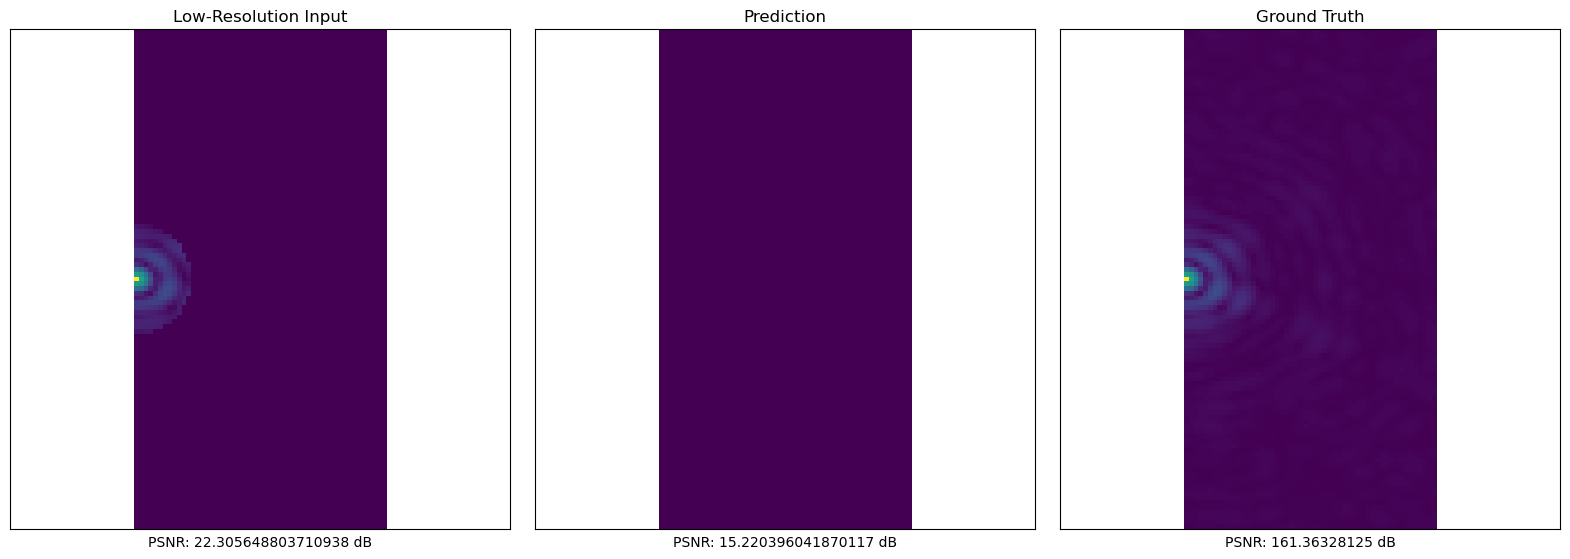

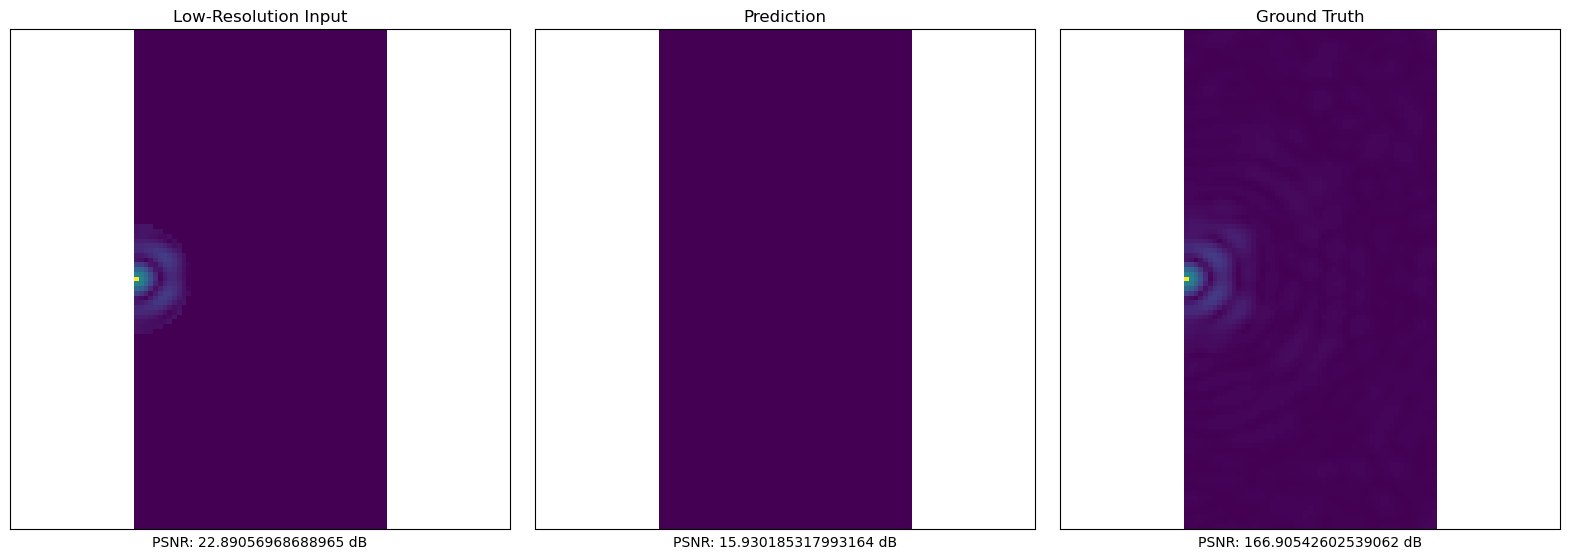

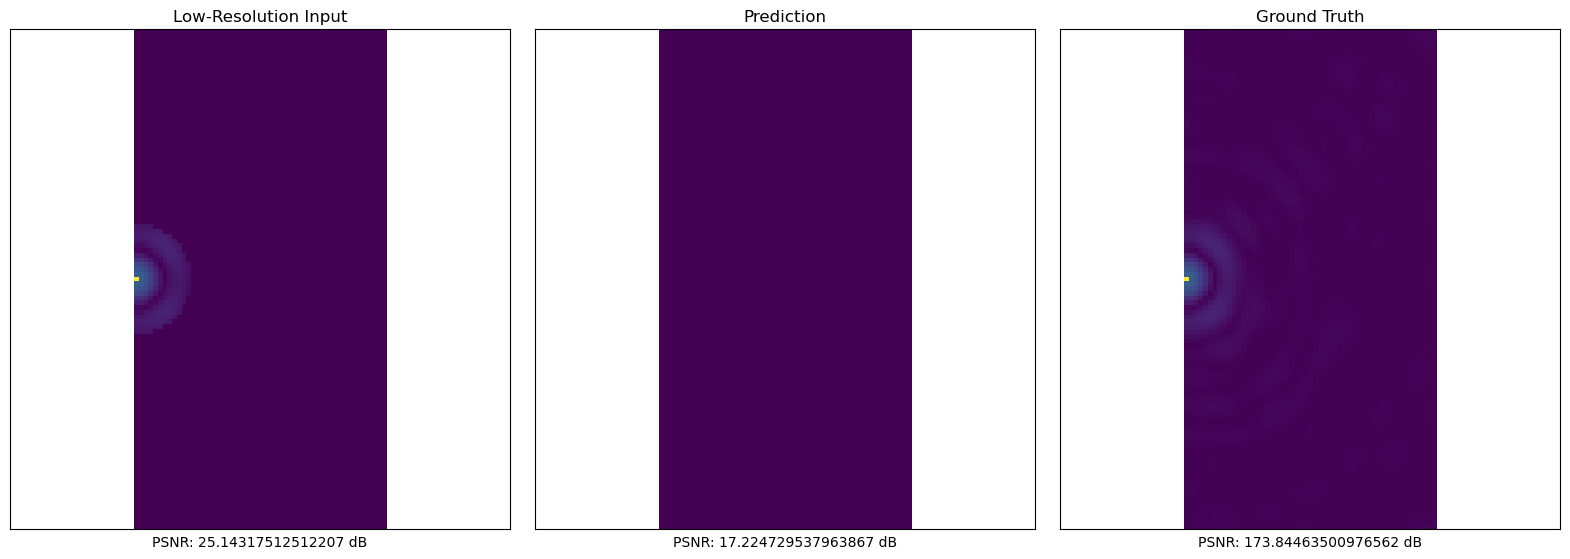

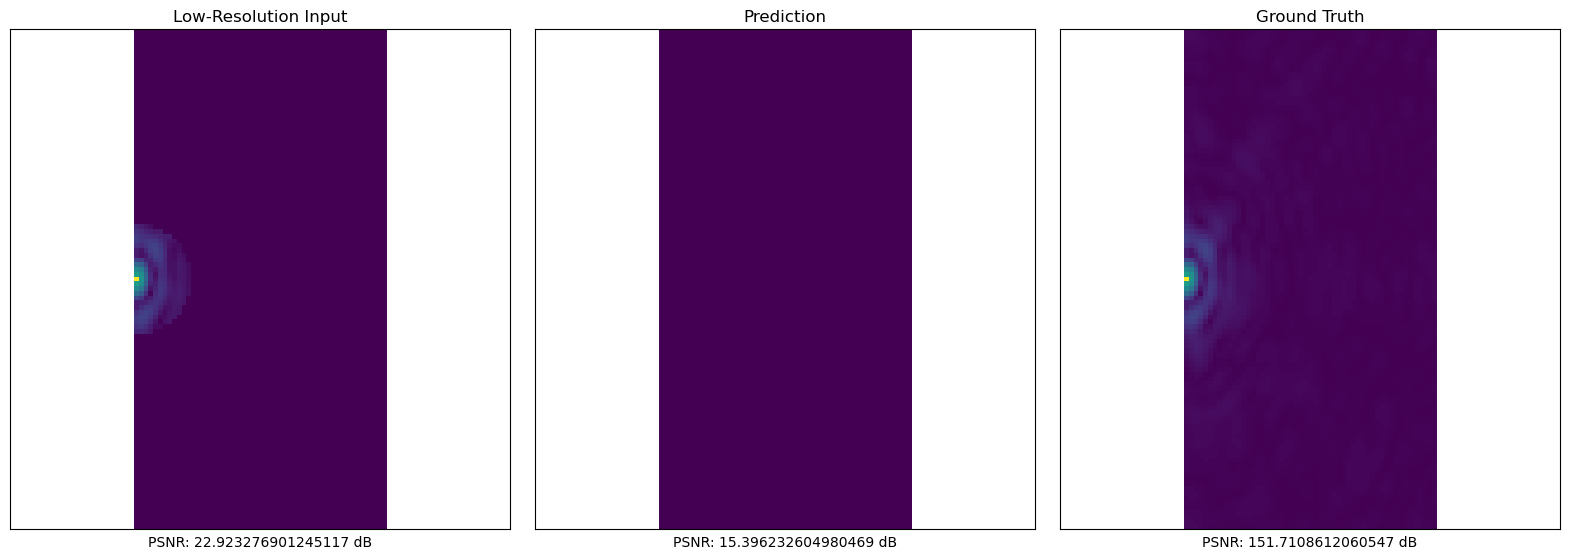

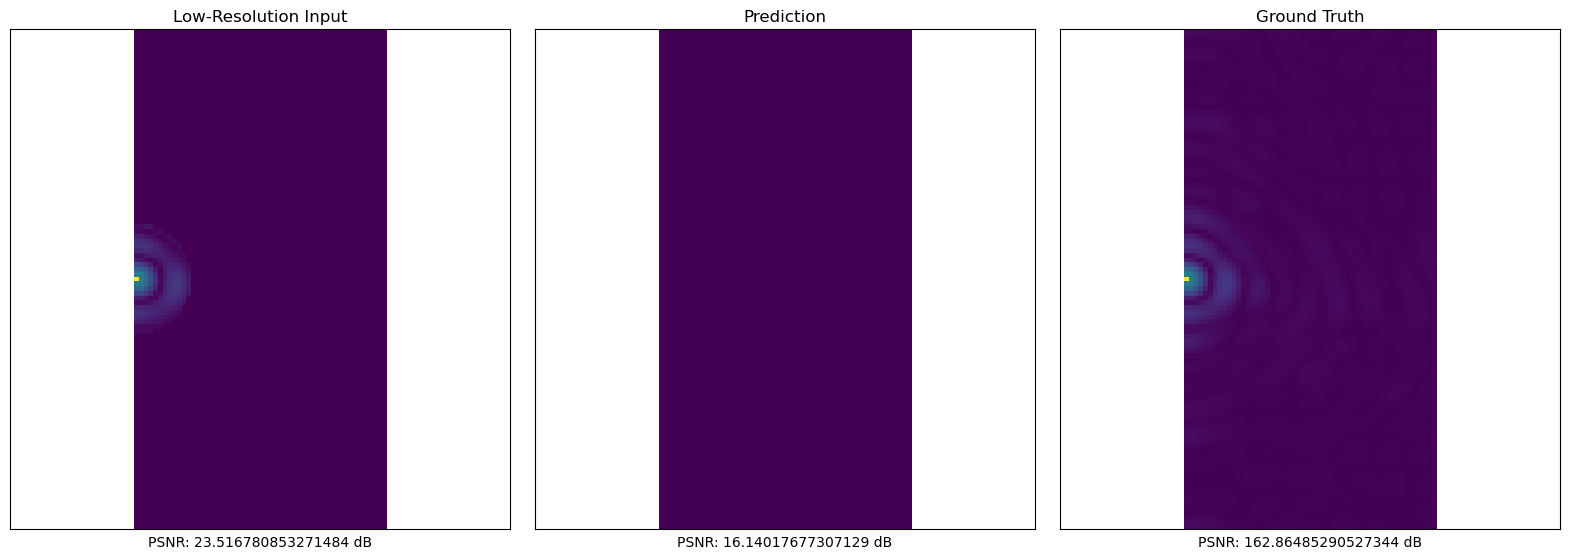

In [9]:
def predict_one_test_batch(no_of_images = 2):
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break

    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    x_input = fc[:, flatten_order][:, :model.input_seq_length]
    gt = fc[:, flatten_order]

    # with torch.no_grad():
        # pred = model.sres.forward_inference(x_input,max_seq_length=gt.shape[1])
    # pred[:,:,1] = gt[:,:,1]
    pred = torch.zeros_like(gt)
    fig = plt.figure()
    lowres = torch.zeros_like(pred)
    lowres[:, :model.input_seq_length] = x_input
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)



    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)
    gt_psnr = PSNR(gt_img,gt_img)

    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True )
    fig.legend()
    plt.savefig('psnr_diff.png')
    plt.close()
    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    for sample in range(no_of_images):
        fig2 = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1,5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.set_title('Low-Resolution Input');
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(pred_img[sample].cpu(), cmap='gray')
        ax1.set_title('Prediction');
        ax1.axis('equal');


        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(gt_img[sample].cpu(), cmap='gray')
        ax2.set_title('Ground Truth');
        ax2.axis('equal');

    from sklearn.random_projection import sample_without_replacement


    for i in range(no_of_images):
        sample = i
        fig = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');

predict_one_test_batch(5)